In [109]:
%matplotlib inline
import matplotlib.pyplot as plt
# the hrf model to be used for data constructions
from nistats.hemodynamic_models import spm_hrf
# compute betaseries correlations
from nibetaseries.interfaces.nistats import BetaSeries
# make AR(1) correlated error terms
from statsmodels.tsa.arima_process import ArmaProcess
# generate optimal experimental designs
from neurodesign import optimisation,experiment
# make correlated betas
from scipy.linalg import cholesky
# numerical operations
import numpy as np
# convient to create tsvs
import pandas as pd
# create/operate on nifti images
import nibabel as nib

from collections import namedtuple, Counter
import tempfile
import os

# Beta Series Simulations

Testing [NiBetaSeries](https://github.com/HBClab/NiBetaSeries) with 

In [2]:
# repetition time of the MRI image
tr = 2
# number of experimental trials
n_trials = 80
# number of trial types (elijah wood and daniel radcliff)
n_trialtypes = 2
# minimum intertrial interval
iti_min = 3.5
# mean intertrial interval
iti_mean = 10
# maximum intertrial interval
iti_max = 20
# how to sample itis (mostly small, but a few larger ones)
iti_model = 'exponential'
# how long the stimulus is presented
stim_duration = 0.2
# stimulus probability (each stimulus is equally likely to occur)
stim_prob = [1 / n_trialtypes] * n_trialtypes
# contrasts of interest (dependent on n_trialtypes)
contrasts = [[1, 0], [0, 1], [1, -1]]
# resolution for the data generation process
des_res = 0.1
# autocorrelation for data
rho = 0.12
# set random seed for reproducibility
np.random.seed(12345)

In [3]:
Experiment = experiment(
    TR=tr,
    n_trials=n_trials,
    P=stim_prob,
    C=contrasts,
    n_stimuli=n_trialtypes,
    rho=rho,
    resolution=des_res,
    stim_duration=stim_duration,
    ITImodel=iti_model,
    ITImin=iti_min,
    ITImean=iti_mean,
    ITImax=iti_max
    )

/home/james/.conda/envs/sim_test/lib/python3.6/site-packages/neurodesign/classes.py:410: UserWarning: Warning: the resolution is adjusted to be a multiple of the TR.  New resolution: 0.100000
  warnings.warn("Warning: the resolution is adjusted to be a multiple of the TR.  New resolution: %f"%self.resolution)
/home/james/.conda/envs/sim_test/lib/python3.6/site-packages/neurodesign/classes.py:560: RuntimeWarning: divide by zero encountered in log
  res = (h - 1) * np.log(s) + h * np.log(l) - l * s - np.log(gamma(h))


In [4]:
# find best design
Designer = optimisation(
    experiment=Experiment,
    weights=[0, 0.25, 0.5, 0.25],
    preruncycles=2,
    cycles=100,
    optimisation='GA'
    )

Designer.optimise()

100% |########################################################################|
100% |########################################################################|


In [5]:
# cannot use PopMax.bestdesign.Xnonconv because resolution information is lost
# (if I care about testing jitter)

In [6]:
# https://quantcorner.wordpress.com/2018/02/09/generation-of-correlated-random-numbers-using-python/
# mean of the betas pulled from Mumford (2012) (hard coded!)
betas_mean = [5.0, 5.0, 5.0, 5.0]
# standard deviation for the betas (hard coded!)
betas_sd = [0.5, 0.5, 0.5, 0.5]
# beta network correlation for seeing elijah wood
wcorr_ew = 0.8
# beta network correlation for seeing daniel radcliff
wcorr_dr = 0.4
# the correlation between the elijah wood and daniel radcliff networks
bcorr = 0.0
# the number of trials per trial type
beta_matrix_rows = int(n_trials / n_trialtypes)
# the number of voxels to simulate
n_voxels = 2
# each trial type gets a column for each voxel
beta_matrix_columns = int(n_trialtypes * n_voxels)

# full correlation matrix (hard coded!)
corr_mat = np.array([[1.0, wcorr_ew, bcorr, bcorr],
                     [wcorr_ew, 1.0, bcorr, bcorr],
                     [bcorr, bcorr, 1.0, wcorr_dr],
                     [bcorr, bcorr, wcorr_dr, 1.0]])

# compute the (upper) Cholesky decomposition matrix
upper_chol = cholesky(corr_mat)

# generate random betas
rnd = np.random.normal(betas_mean, betas_sd,
                       size=(beta_matrix_rows, beta_matrix_columns))

# finally, compute the inner product of upper_chol and rnd
betas = rnd @ upper_chol

# see how closely generated data matches assumptions
ground_truth = np.corrcoef(betas.T)

# elijah wood's ground truth beta correlation (hard coded!)
truth_ew = ground_truth[0, 1]
# daniel radcliff's ground truth beta correlation (hard coded!)
truth_dr = ground_truth[2, 3]
print('Elijah Wood within network correlation:     {}'.format(truth_ew))
print('Daniel Radcliff within network correlation: {}'.format(truth_dr))

Elijah Wood within network correlation:     0.7648639577549889
Daniel Radcliff within network correlation: 0.3500235750233779


In [7]:
cond_order = Designer.bestdesign.order
# divide by design resolution to have same resolution as experiment generation process
onsets = Designer.bestdesign.onsets / des_res
onsets = onsets.astype(int)
# allocate design matrix (one column per trial)
X = np.zeros((int(Designer.bestdesign.experiment.duration / des_res), onsets.shape[0]))
# allocate betas (two columns for 2 voxels)
B = np.zeros((onsets.shape[0], 2))
# the stimulus duration represented in the design resolution
stim_duration_msec = int(stim_duration / des_res)
# oversampling at the rate of the design resolution
sampling_rate = int(tr / des_res)
# counters for elijah wood and daniel radcliff stimuli
cond_ew = 0
cond_dr = 0

# create the design matrix for the data generation process
for idx, (cond, onset) in enumerate(zip(cond_order, onsets)):
    # set the design matrix
    X[onset:onset+stim_duration_msec, idx] = 1
    X[:, idx] = np.convolve(X[:, idx], spm_hrf(tr, oversampling=sampling_rate))[0:X.shape[0]]
    # set the beta for the trial depending on condition
    if cond == 0:
        B[idx, :] = betas[cond_ew, 0:2]
        cond_ew += 1
    elif cond == 1:
        B[idx, :] = betas[cond_dr, 2:4]
        cond_dr += 1

# downsample X so it's back to TR resolution
X = X[::sampling_rate, :]

/home/james/.conda/envs/sim_test/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)


In [8]:
n_trs = int(Designer.bestdesign.experiment.duration / tr)

In [43]:
# AR(1) process with 1 lag with a .12 correlation (Mumford et al. 2012)
sd_err = 0.08
ar = np.array([1, -rho])
ap = ArmaProcess(ar)
err = ap.generate_sample((n_trs, 2), scale=sd_err, axis=0)

In [44]:
Y = X @ B + err

In [45]:
# define signal to noise: http://www.scholarpedia.org/article/Signal-to-noise_ratio
signal = X @ B
noise = err

np.mean(signal[:,0] ** 2) / np.var(err)

2.9287984597446473

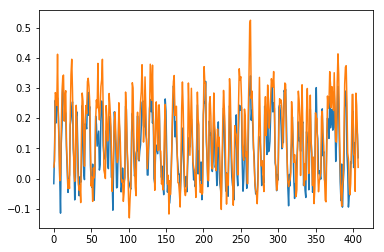

In [11]:
plt.plot(Y)

In [12]:
# Make events file
events_file = 'events.tsv'
collector = {'onset': [], 
             'duration': [], 
             'correct': [],
             'trial_type': []}
for cond, onset in zip(cond_order, onsets):
    if cond == 0:
        collector['trial_type'].append('elijah_wood')
    elif cond == 1:
        collector['trial_type'].append('daniel_radcliffe')

    collector['onset'].append(onset * des_res)
    collector['duration'].append(stim_duration)
    collector['correct'].append(1)

events_df = pd.DataFrame.from_dict(collector)
events_df.to_csv(events_file, sep='\t', index=False)

In [13]:
# create bold nifti
bold_file = 'bold_file.nii.gz'
bold_data = np.array([[Y.T]])
bold_img = nib.Nifti1Image(bold_data, np.eye(4))
bold_img.to_filename(bold_file)

# create mask nifti
mask_file = 'brainmask.nii.gz'
mask_data = np.array([[[1, 1]]], dtype=np.int16)
mask_img = nib.Nifti1Image(mask_data, np.eye(4))
mask_img.to_filename(mask_file)

In [14]:
# bold_metadata
bold_metadata = {"RepetitionTime": tr, "TaskName": "whodis"}

In [15]:
beta_series = BetaSeries(bold_file=bold_file,
                         bold_metadata=bold_metadata,
                         confounds_file=None,
                         events_file=events_file,
                         hrf_model='spm',
                         low_pass=None,
                         mask_file=mask_file,
                         selected_confounds=None,
                         smoothing_kernel=None)

In [16]:
result = beta_series.run()

/home/james/.conda/envs/sim_test/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
Computing run 1 out of 1 runs (go take a coffee, a big one)
/home/james/.conda/envs/sim_test/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/james/.conda/envs/sim_test/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big o


Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds



In [17]:
result.outputs.beta_maps

['/media/Data/Documents/devel/betaSim/betaseries_trialtype-daniel_radcliffe.nii.gz',
 '/media/Data/Documents/devel/betaSim/betaseries_trialtype-elijah_wood.nii.gz']

In [18]:
for bmap in result.outputs.beta_maps:
    if 'elijah_wood' in bmap:
        bm_ew = nib.load(bmap)
    elif 'daniel_radcliffe' in bmap:
        bm_dr = nib.load(bmap)

In [19]:
betas_ew = np.squeeze(bm_ew.get_data())
betas_dr = np.squeeze(bm_dr.get_data())

In [20]:
np.corrcoef(betas_dr)

array([[1.        , 0.14243625],
       [0.14243625, 1.        ]])

In [46]:
truth_ew - np.corrcoef(betas_ew)[0, 1]

0.30661263969466696

# Simulations

I would like to test the impact of jitter on correlations, the length of the ITI, how much noise is necessary/how to represent noise

In [119]:
class BetaSeriesSimulation:


    def __init__(self, tr=2, n_trials=80, n_trialtypes=2,
                 iti_min=2, iti_mean=4, iti_max=16,
                 iti_model='exponential', stim_duration=0.2,
                 contrasts=[[1, 0], [0, 1], [1, -1]],
                 des_res=0.1, rho=0.12, sd_err=0.08,
                 n_simulations=500):
        """Class for performing and containing results from simulations

        Parameters
        ----------

        tr : int
            repetition time of the fMRI bold series
        n_trials : int
            number of experimental trials
        n_trialtypes : int
            number of trial types
        iti_min : float
            minimum intertrial interval
        iti_mean : float
            mean intertrial interval
        iti_max : float
            maximum intertrial interval
        iti_model : str
            distribution to sample iti's from 
            (choices: “fixed”,”uniform”,”exponential”)
        stim_duration : float
            how long each stimulus is presented
        contrasts : list
            contrasts of interest (dependent on n_trialtypes)
        des_res : float
            design resolution for the data generation process
        rho : float
            AR(1) correlation coefficient
        sd_err : float
            the standard deviation for the error term
        n_simulations : int
            number of iterations for the simulation


        Attributes
        ----------

        tr : int
            repetition time of the fMRI bold series
        n_trials : int
            number of experimental trials
        n_trialtypes : int
            number of trial types
        iti_min : float
            minimum intertrial interval
        iti_mean : float
            mean intertrial interval
        iti_max : float
            maximum intertrial interval
        iti_model : str
            distribution to sample iti's from 
            (choices: “fixed”,”uniform”,”exponential”)
        stim_duration : float
            how long each stimulus is presented
        contrasts : list
            contrasts of interest (dependent on n_trialtypes)
        des_res : float
            design resolution for the data generation process
        rho : float
            AR(1) correlation coefficient
        sd_err : float
            the standard deviation for the error term
        n_simulations : int
            number of iterations for the simulation
        Designer : neurodesign.optimisation
            optimized experimental design object
        simulation_results : pandas.DataFrame
            the collection of the true correlations and the 
            estimated correlations from betaseries correlations.
        """

        self.tr = tr
        self.n_trials = n_trials
        self.n_trialtypes = n_trialtypes
        self.iti_min = iti_min
        self.iti_mean = iti_mean
        self.iti_max = iti_max
        self.iti_model = iti_model
        self.stim_duration = stim_duration
        self.contrasts = contrasts
        self.des_res = des_res
        self.rho = rho
        self.sd_err = sd_err
        self.tmp_dir = tempfile.mkdtemp(prefix='simulation_')
        self.n_simulations = n_simulations
        
        # set by _make_design
        self.Designer = None

        # set by run_simulations
        self.simulation_results = None

        
    def make_design(self):
        """generates an optimized experimental design
        """
        # stimulus probability (each stimulus is equally likely to occur)
        stim_prob = [1 / self.n_trialtypes] * self.n_trialtypes
        
        # setup experimental parameters
        Experiment = experiment(
            TR=self.tr,
            n_trials=self.n_trials,
            P=stim_prob,
            C=self.contrasts,
            n_stimuli=self.n_trialtypes,
            rho=self.rho,
            resolution=self.des_res,
            stim_duration=self.stim_duration,
            ITImodel=self.iti_model,
            ITImin=self.iti_min,
            ITImean=self.iti_mean,
            ITImax=self.iti_max)

        # find best design
        Designer = optimisation(
            experiment=Experiment,
            weights=[0, 0.25, 0.5, 0.25],
            preruncycles=2,
            cycles=100,
            optimisation='GA')

        # keep optimizing until there are an equal...
        # ..number of trials for each trialtype
        optimise = True
        while optimise:
            Designer.optimise()
            trial_count = list(Counter(Designer.bestdesign.order).values())
            # try again if conditions do have equal trials
            optimise = not all(x == trial_count[0] for x in trial_count)
        
        self.Designer = Designer
    

    def run_simulations(self):
        """simulates data and performs correlations
        """
        cond_order = self.Designer.bestdesign.order
        onsets = self.Designer.bestdesign.onsets
        duration = self.Designer.bestdesign.experiment.duration
        
       
        simulation_results_dict = {'true_corr_ew': [],
                                   'true_corr_dr': [],
                                   'snr': [],
                                   'corr_ew': [],
                                   'corr_dr': []}
        # simulate data
        for _ in range(self.n_simulations):
            gen_betas = self._generate_betas()
            simulation_results_dict['true_corr_ew'].append(gen_betas.true_corr_ew)
            simulation_results_dict['true_corr_dr'].append(gen_betas.true_corr_dr)
            
            sim_data = self._simulate_data(gen_betas.betas, cond_order, onsets, duration)
            simulation_results_dict['snr'].append(sim_data.snr)
            
            events_file = self._make_events_tsv(cond_order, onsets, duration)
            bold_file = self._make_bold_nifti(Y=sim_data.Y)
            mask_file = self._make_mask_nifti()
            bold_metadata = {"RepetitionTime": self.tr, "TaskName": "whodis"}
            
            beta_results = self._run_betaseries(bold_file, bold_metadata, events_file, mask_file)
            simulation_results_dict['corr_ew'].append(beta_results.corr_ew)
            simulation_results_dict['corr_dr'].append(beta_results.corr_dr)
        
        # make an analyzable dataframe from the simulated results
        self.simulation_results = pd.DataFrame.from_dict(simulation_results_dict)



    def _generate_betas(self):
        """
        makes the simulated beta values
        
        Returns
        -------
        
        betas : numpy.array
            numpy array size (n_trials / n_trialtypes) x (n_trials * n_voxels)
            to give each trialtype their unique betas per voxel
        
        true_corr_ew : float
            the correlation between the two elijah wood voxels
        
        true_corr_dr : float
            the correlation between the two daniel radcliffe voxels
            
        """
        # https://quantcorner.wordpress.com/2018/02/09/generation-of-correlated-random-numbers-using-python/
        # mean of the betas pulled from Mumford (2012) (hard coded!)
        betas_mean = [5.0, 5.0, 5.0, 5.0]
        # standard deviation for the betas (hard coded!)
        betas_sd = [0.5, 0.5, 0.5, 0.5]
        # beta network correlation for seeing elijah wood
        wcorr_ew = 0.8
        # beta network correlation for seeing daniel radcliff
        wcorr_dr = 0.4
        # the correlation between the elijah wood and daniel radcliff networks
        bcorr = 0.0
        # the number of trials per trial type
        beta_matrix_rows = int(self.n_trials / self.n_trialtypes)
        # the number of voxels to simulate
        n_voxels = 2
        # each trial type gets a column for each voxel
        beta_matrix_columns = int(self.n_trialtypes * n_voxels)

        # full correlation matrix (hard coded!)
        corr_mat = np.array([[1.0, wcorr_ew, bcorr, bcorr],
                             [wcorr_ew, 1.0, bcorr, bcorr],
                             [bcorr, bcorr, 1.0, wcorr_dr],
                             [bcorr, bcorr, wcorr_dr, 1.0]])

        # compute the (upper) Cholesky decomposition matrix
        upper_chol = cholesky(corr_mat)

        # generate random betas
        rnd = np.random.normal(betas_mean, betas_sd,
                               size=(beta_matrix_rows, beta_matrix_columns))

        # finally, compute the inner product of upper_chol and rnd
        betas = rnd @ upper_chol

        # see how closely generated data matches assumptions
        ground_truth = np.corrcoef(betas.T)

        # elijah wood's ground truth beta correlation (hard coded!)
        true_corr_ew = ground_truth[0, 1]
        # daniel radcliff's ground truth beta correlation (hard coded!)
        true_corr_dr = ground_truth[2, 3]

        SimulatedBetas = namedtuple('SimulatedBetas', 'betas true_corr_ew true_corr_dr')

        return SimulatedBetas(betas=betas, true_corr_ew=true_corr_ew, true_corr_dr=true_corr_dr)

    
    def _simulate_data(self, betas, cond_order, onsets, duration):
        """simulates the data for the voxels
        
        Parameters
        ----------
        
        betas : numpy.array
            numpy array size (n_trials / n_trialtypes) x (n_trials * n_voxels)
            to give each trialtype their unique betas per voxel
        cond_order : list
            each entry is an integer representing the trialtype for that
            particular trial
        onsets : numpy.array
            identifies each onset (in seconds) for a trial to occur
        duration : float
            the total length (in seconds) of the experiment
        
        Returns
        -------
        
        Y : numpy.array
            the simulated data with the size n_volumes x n_voxels
        snr : float
            a measure of signal to noise
        """
        # divide by design resolution to have same resolution as experiment generation process
        onsets = onsets / self.des_res
        onsets = onsets.astype(int)
        # allocate design matrix (one column per trial)
        X = np.zeros((int(duration / self.des_res), onsets.shape[0]))
        # allocate betas (two columns for 2 voxels)
        B = np.zeros((onsets.shape[0], 2))
        # the stimulus duration represented in the design resolution
        stim_duration_msec = int(self.stim_duration / self.des_res)
        # oversampling at the rate of the design resolution
        sampling_rate = int(self.tr / self.des_res)
        # counters for elijah wood and daniel radcliff stimuli
        cond_ew = 0
        cond_dr = 0

        # create the design matrix for the data generation process
        for idx, (cond, onset) in enumerate(zip(cond_order, onsets)):
            # set the design matrix
            X[onset:onset+stim_duration_msec, idx] = 1
            X[:, idx] = np.convolve(X[:, idx], spm_hrf(tr, oversampling=sampling_rate))[0:X.shape[0]]
            # set the beta for the trial depending on condition
            if cond == 0:
                B[idx, :] = betas[cond_ew, 0:2]
                cond_ew += 1
            elif cond == 1:
                B[idx, :] = betas[cond_dr, 2:4]
                cond_dr += 1

        # downsample X so it's back to TR resolution
        X = X[::sampling_rate, :]

        # make the noise component
        n_trs = int(duration / self.tr)
        ar = np.array([1, -self.rho]) # statmodels says to invert rho
        ap = ArmaProcess(ar)
        n_voxels = 2
        err = ap.generate_sample((n_trs, n_voxels), scale=self.sd_err, axis=0)

        # define signal to noise: http://www.scholarpedia.org/article/Signal-to-noise_ratio
        signal = X @ B
        noise = err

        snr = np.mean(signal[:,0] ** 2) / np.var(err)

        # simulated data
        Y = signal + noise

        SimulatedData = namedtuple('SimulatedData', 'Y snr')

        return SimulatedData(Y=Y, snr=snr)


    def _make_events_tsv(self, cond_order, onsets, duration):
        """creates events.tsv file
        
        Parameters
        ----------
        
        cond_order : list
            each entry is an integer representing the trialtype for that
            particular trial
        onsets : numpy.array
            identifies each onset (in seconds) for a trial to occur
        duration : float
            the total length (in seconds) of the experiment
            
        Returns
        -------
        
        events_file : str
            pathname to the events file
        """
        events_file = os.path.join(self.tmp_dir, 'events.tsv')
        collector = {'onset': [], 
                     'duration': [], 
                     'correct': [],
                     'trial_type': []}
        for cond, onset in zip(cond_order, onsets):
            if cond == 0:
                collector['trial_type'].append('elijah_wood')
            elif cond == 1:
                collector['trial_type'].append('daniel_radcliffe')

            collector['onset'].append(onset * self.des_res)
            collector['duration'].append(duration)
            collector['correct'].append(1)

        events_df = pd.DataFrame.from_dict(collector)
        events_df.to_csv(events_file, sep='\t', index=False)
        
        return events_file


    def _make_bold_nifti(self, Y):
        """creates bold file
        
        Paramters
        ---------
        
        Y : numpy.array
            the simulated data with the size n_volumes x n_voxels
            
        Returns
        -------
        
        bold_file : str
            pathname to the bold file
        """
        bold_file = os.path.join(self.tmp_dir, 'bold_file.nii.gz')
        bold_data = np.array([[Y.T]])
        bold_img = nib.Nifti1Image(bold_data, np.eye(4))
        bold_img.to_filename(bold_file)

        return bold_file
    

    def _make_mask_nifti(self):
        """creates mask file (assumes 2 voxels)
            
        Returns
        -------
        
        mask_file : str
            pathname to the mask file
        """
        mask_file = os.path.join(self.tmp_dir, 'brainmask.nii.gz')
        mask_data = np.array([[[1, 1]]], dtype=np.int16)
        mask_img = nib.Nifti1Image(mask_data, np.eye(4))
        mask_img.to_filename(mask_file)

        return mask_file


    def _run_betaseries(self, bold_file, bold_metadata, events_file, mask_file):
        """runs betaseries correlations
        
        Parameters
        ----------
        
        bold_file : str
            pathname to a bold file
        bold_metadata : dict
            dictionary containing tr and task information
        events_file : str
            pathname to an events file
        mask_file : str
            pathname to a mask file
            
        Returns
        -------
        
        corr_ew : float
            estimated betaseries correlation for elijah wood
        corr_dr : float
            estimated betaseries correlation for daniel radcliffe
        """
        beta_series = BetaSeries(bold_file=bold_file,
                                 bold_metadata=bold_metadata,
                                 confounds_file=None,
                                 events_file=events_file,
                                 hrf_model='spm',
                                 low_pass=None,
                                 mask_file=mask_file,
                                 selected_confounds=None,
                                 smoothing_kernel=None)

        result = beta_series.run(cwd=self.tmp_dir)

        for bmap in result.outputs.beta_maps:
            if 'elijah_wood' in bmap:
                bm_ew = nib.load(bmap)
            elif 'daniel_radcliffe' in bmap:
                bm_dr = nib.load(bmap)

        betas_ew = np.squeeze(bm_ew.get_data())
        betas_dr = np.squeeze(bm_dr.get_data())
        corr_ew = np.corrcoef(betas_ew)[0, 1]
        corr_dr = np.corrcoef(betas_dr)[0, 1]

        ModeledCorrs = namedtuple('ModeledCorrs', ' corr_ew corr_dr')
        return ModeledCorrs(corr_ew=corr_ew, corr_dr=corr_dr)

In [141]:
test_sim = BetaSeriesSimulation(sd_err=0.04, n_simulations=10)

In [142]:
test_sim.make_design()

/home/james/.conda/envs/sim_test/lib/python3.6/site-packages/neurodesign/classes.py:410: UserWarning: Warning: the resolution is adjusted to be a multiple of the TR.  New resolution: 0.100000
  warnings.warn("Warning: the resolution is adjusted to be a multiple of the TR.  New resolution: %f"%self.resolution)
/home/james/.conda/envs/sim_test/lib/python3.6/site-packages/neurodesign/classes.py:560: RuntimeWarning: divide by zero encountered in log
  res = (h - 1) * np.log(s) + h * np.log(l) - l * s - np.log(gamma(h))
100% |########################################################################|
100% |########################################################################|


In [143]:
test_sim.run_simulations()

/home/james/.conda/envs/sim_test/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/james/.conda/envs/sim_test/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
Computing run 1 out of 1 runs (go take a coffee, a big one)
/home/james/.conda/envs/sim_test/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big o


Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a


Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a


Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a


Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a


Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a


Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a


Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a


Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs done in 0 seconds

Computing run 1 out of 1 runs (go take a coffee, a big one)

Computation of 1 runs

In [144]:
test_sim.simulation_results.to_csv('itimean-10_summary.tsv', sep='\t', index=False)

In [145]:
test_sim.simulation_results

,true_corr_ew,true_corr_dr,snr,corr_ew,corr_dr
0,0.770692,0.429089,46.315291,0.990575,0.983927
1,0.721179,0.450550,42.443387,0.995968,0.992200
2,0.802495,0.474467,41.855684,0.990407,0.983015
3,0.790083,0.532996,55.370775,0.991530,0.986643
4,0.765310,0.590772,45.103274,0.994269,0.989078
5,0.794521,0.299482,38.958938,0.992738,0.989923
6,0.729910,0.363910,45.847857,0.977119,0.978635
7,0.771851,0.417347,45.284606,0.984429,0.990268
8,0.839961,0.316654,43.605820,0.976445,0.975332
9,0.831970,0.219455,45.436144,0.973405,0.969230
